Model Training in Pytorch
=============================

-------------
Author: [Vinkle Srivastav](http://camma.u-strasbg.fr/people)

In this notebook we will learn how to train a simple convolutional neural network on the MNIST dataset.

### Import libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary

import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import sys
print("Using PyTorch Version: ",torch.__version__)
print("Using Torchvision Version: ",torchvision.__version__)

Using PyTorch Version:  1.2.0
Using Torchvision Version:  0.4.0


Settings
------

In [2]:
colab = False
if colab:
    root_dir='./'
    data_dir = './'
else:
    root_dir='./'
    os.makedirs(os.path.join(root_dir, 'datasets'))
    data_dir = os.path.join(root_dir, "datasets")


dataset_mnist_mean = 0.1307
dataset_mnist_std = 0.3081

# Batch size for training (change depending on how much memory you have)
batch_size = 32

criterion = nn.CrossEntropyLoss()

# Number of epochs to train for 
num_epochs = 20
# learning rate
learning_rate = 0.001
momentum = 0.9
weight_decay = 0.001

# if you don't want to perform the training, use it load the model and training history
trained_model_path = os.path.join(root_dir, 'models/pytorch/train/pytorch_mnist.pt')

# choosing the device
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print("using device '{}' ".format(device))

using device 'cpu' 


#### **Define image transformation to apply on the input image. Different set of transformation can be applied to an image depending upon if it is train, test image**

All the transformations can be accessed here : https://pytorch.org/docs/stable/torchvision/transforms.html

**A helper function to plot images from torch tensors**

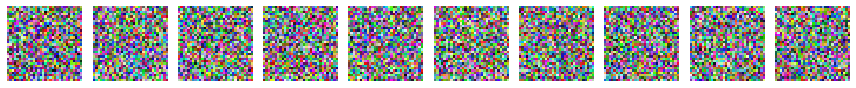

In [3]:
def imshow(tensors, GT=None, pred=None, limit = None):
    """
    Plot images and title of the class from torch tensor
    Arguments:
        tensors {[torch.Tensor]} -- Torch tensor of shape NxCxHxW
        GT {[list]} -- list of string of length N, each item is a name of ground-truth class of tensors's ith image
        pred {[list]} -- list of string of length N, each item is a name of prediction class of tensors's ith image
    Returns:
        None
    """
    if limit is None:
        N = tensors.shape[0]
    else:
        assert isinstance(limit, int)
        N = limit
    C = tensors.shape[1]
    plt.figure(figsize=(12, 6))
    for i in range(N):
        plt.subplot(1, N, i + 1)
        # take the ithe image, and convert from CxHxW to HxWxC
        if C == 1:
            img = tensors[i].cpu().squeeze().numpy()
        elif C == 3:
            img = tensors[i].cpu().squeeze().numpy().transpose(1, 2, 0)
        else:
            print('tensor is not formatted properly')
            return None
        # rescale the image
        vmin, vmax = img.min(), img.max()
        img = (img - vmin) / (vmax - vmin)
        # show the image
        plt.imshow(img)
        title = ''
        if GT is not None:
            title += 'gt:' + GT[i]
        if pred is not None:    
            title += '/' + 'pr:'+pred[i]
        plt.title(title)
        plt.axis('off')
        plt.grid()
    plt.gcf().tight_layout()
    return None  

# visualize random tesnors
imshow(torch.rand(10,3,32,32))

In [4]:
def data_transforms():
    data_transforms = {
        'train': transforms.Compose([
           transforms.RandomRotation(20.0),
           transforms.ToTensor(),
           transforms.Normalize((dataset_mnist_mean,), (dataset_mnist_std,))
        ]),
        'val': transforms.Compose([
           transforms.ToTensor(),
           transforms.Normalize((dataset_mnist_mean,), (dataset_mnist_std,))
        ])
    }
    return data_transforms
transformations = data_transforms()

<br>Following code snippet shows how to load and visualize a `MNIST` dataset.<br>
Other popular deep-learning datasets as shown in the table below can also be load using the same procedure (see https://github.com/pytorch/vision/tree/master/torchvision/datasets).

| Dataset | Description |
| --- | --- |
| Caltech101 | http://www.vision.caltech.edu/Image_Datasets/Caltech101/ |
| CelebA | Large-scale CelebFaces Attributes (CelebA) Dataset <http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html> |
| Cityscapes  | http://www.cityscapes-dataset.com |
| MS COCO | http://mscoco.org/dataset |
| Flickr | Parser for extracting captions from the Flickr8k dataset web page |
| HMDB51 | http://serre-lab.clps.brown.edu/resource/hmdb-a-large-human-motion-database |
| ImageNet | http://image-net.org |
| Kinetics400 | https://deepmind.com/research/open-source/open-source-datasets/kinetics |
| LSUN | http://lsun.cs.princeton.edu |
| MNIST | http://yann.lecun.com/exdb/mnist/ |
| Omniglot  | https://github.com/brendenlake/omniglot |
| PhotoTour | Learning Local Image Descriptors Dataset http://phototour.cs.washington.edu/patches/default.htm |
| SBDataset | Semantic Boundaries Dataset <http://home.bharathh.info/pubs/codes/SBD/download.html> |
| SBU | SBU Captioned Photo <http://www.cs.virginia.edu/~vicente/sbucaptions/> |
| SEMEION  | http://archive.ics.uci.edu/ml/datasets/semeion+handwritten+digit |
| SVHN | http://ufldl.stanford.edu/housenumbers/ |
| UCF101 | https://www.crcv.ucf.edu/data/UCF101.php |
| USPS | https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass.html#usps |
| Pascal VOC | http://host.robots.ox.ac.uk/pascal/VOC |

In [6]:
mnist_trainset = datasets.MNIST(root=data_dir, 
                                train=True, 
                                download=True, 
                                transform=transformations['train'])
print('Train Dataset:', mnist_trainset)
mnist_valset = datasets.MNIST(root=data_dir, 
                               train=False, 
                               download=True, 
                               transform=transformations['val'])
print('Val Dataset:', mnist_valset)

# define train loader
mnist_trainloader = torch.utils.data.DataLoader(mnist_trainset, 
                                                batch_size=batch_size, 
                                                shuffle=True, 
                                                num_workers=4)
# define val loader
mnist_valloader = torch.utils.data.DataLoader(mnist_valset, 
                                              batch_size=batch_size, 
                                              shuffle=True, num_workers=4)

dataloaders = {'train':mnist_trainloader, 'val':mnist_valloader}

100.1%

Extracting ./datasets\MNIST\raw\train-images-idx3-ubyte.gz to ./datasets\MNIST\raw


113.5%

Extracting ./datasets\MNIST\raw\train-labels-idx1-ubyte.gz to ./datasets\MNIST\raw


100.4%

Extracting ./datasets\MNIST\raw\t10k-images-idx3-ubyte.gz to ./datasets\MNIST\raw


180.4%

Extracting ./datasets\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./datasets\MNIST\raw
Processing...
Done!
Train Dataset: Dataset MNIST
    Number of datapoints: 60000
    Root location: ./datasets
    Split: Train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=(-20.0, 20.0), resample=False, expand=False)
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )
Val Dataset: Dataset MNIST
    Number of datapoints: 10000
    Root location: ./datasets
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )


Number of images in the train-set=60000
Number of images in the test-set=10000



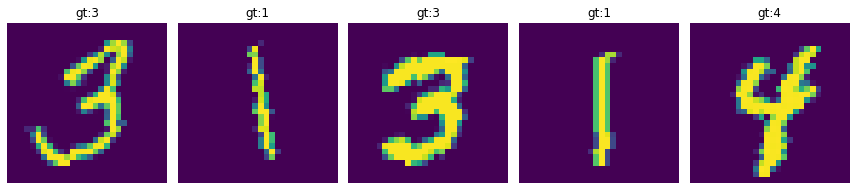

In [7]:
# load and visualize images
print('Number of images in the train-set={}'.format(len(mnist_trainset)))
print('Number of images in the test-set={}\n'.format(len(mnist_valset)))
inputs, classes = next(iter(mnist_trainloader))
imshow(inputs, GT=[str(x.item()) for x in classes], limit=5)

In [ ]:
# measure the performance of train loader
def benchmark_dataloader(loader, no_iter=100):
    measured_time = []
    _temp_loader = iter(loader)
    print('starting the bench marking for data loader')
    for i in range(no_iter):
        t0 = time.time()
        _,_= next(_temp_loader)
        measured_time.append(time.time()-t0)
    mean_time =  np.mean(np.asarray(measured_time)*1e3)
    std_time = np.std(np.asarray(measured_time)*1e3)
    print('Dataloader time for batch size {} = {}+-{} ms'.format(batch_size, 
                                                                 mean_time, 
                                                                 std_time))
    print('{} Samples/Second'.format(batch_size / (mean_time/1e3)))
    return mean_time, std_time

results = benchmark_dataloader(mnist_trainloader)

### CNN Model
Here we define a simple 2 CNN layer and 2 fully connected layer model to train our network. 

In [ ]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, stride=1, padding=1)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(in_features=20*7*7, out_features=50)
        self.fc2 = nn.Linear(in_features=50, out_features=10)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(self.conv2_drop(F.relu(self.conv2(x))), 2)
        x = x.view(-1, 20*7*7)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x


our_tiny_model = MNIST_Net().to(device)
# Observe that all parameters are being optimized
optimizer = optim.SGD(our_tiny_model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

### Model summary
summary(MNIST_Net().to(device), input_size=(1, 28, 28), device=str(device))    

In [ ]:
#summary(models.resnet152().to(device), input_size=(3, 224, 224))
pass

In [ ]:
# benchmarking the model performance
def benchmark_model(model, x, y, device, no_iter=100):
    def measure(model, x, y):
        # measure forward time
        if str(device) == 'cuda':
            torch.cuda.synchronize()
        t0 = time.time()
        y_pred = model(x)
        if str(device) == 'cuda':
            torch.cuda.synchronize()
        f = time.time() - t0
        
        # measure backward time
        model.zero_grad()
        t0 = time.time()
        y_pred.backward(y)
        if str(device) == 'cuda':
            torch.cuda.synchronize()
        b = time.time()-t0
        return f, b 
        
    model = model.to(device)
    x, y = x.to(device), y.to(device)
    # DRY RUNS
    for i in range(5):
        _, _ = measure(model, x, y)
        
    fwd_time, bkw_time = [], []
    for i in range(no_iter):
        f,b = measure(model, x, y)
        fwd_time.append(f)
        bkw_time.append(b)
    
    fwd_mean, fwd_std = np.mean(np.asarray(fwd_time)*1e3),  np.std(np.asarray(fwd_time)*1e3)
    bkw_mean, bkw_std = np.mean(np.asarray(bkw_time)*1e3),  np.std(np.asarray(bkw_time)*1e3)
    
    print('Forward Pass: {}+-{} ms'.format(fwd_mean,fwd_std))
    print('Backward Pass: {}+-{} ms'.format(bkw_mean,bkw_std))
    print('Forward+Backward: {} ms'.format(fwd_mean+bkw_mean))
    
    return fwd_mean, bkw_mean

In [ ]:
# benchmarning for our tiny model
print('our tiny model')
result = benchmark_model(model = our_tiny_model, 
                         x = torch.rand(1,1,28,28).to(device),
                         y = torch.rand(1,10).to(device),
                         device = device
                        )

In [ ]:
# benchmarning for resnet152
print('resnet 152')
result = benchmark_model(model = models.resnet152().to(device), 
                         x = torch.rand(1,3,224,224).to(device),
                         y = torch.rand(1,1000).to(device),
                         device = device
                        )

### Visualize predictions from the untrained model

In [ ]:
break_count = 5
index = 0
for inputs, labels in dataloaders['val']:
    if index == break_count:
        break
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
        # get the model output
        outputs = our_tiny_model(inputs)
        # compute the prediction indices
        _, preds = torch.max(outputs, 1)
        # show the ground truth with predictions
        imshow(inputs, GT=[str(x.item()) for x in labels], 
               pred=[str(x.item()) for x in preds], limit=10)    
    index += 1

### Training and evaluation helper Functions
#### Model Training and Validation Code
The ``train_model`` function handles the training and validation of a given model. As input, it takes a PyTorch model, a dictionary of dataloaders, a loss function, an optimizer, and  a specified number of epochs to train and validate for. The function trains for the specified number of epochs and after each epoch runs a full validation step. It also keeps track of the best performing model (in terms of validation accuracy), and at the end of training returns the best performing model. After each epoch, the training and validation accuracies are printed.

In [ ]:
# train model for 1 epoch
def train(model, dataloader, criterion, optimizer):
    # Set model to training mode
    model.train()  
    running_loss = 0.0
    running_corrects = 0
    # Iterate over data.
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)

        # compute gradient and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    return model, epoch_loss, epoch_acc

def evaluate(model, dataloader, criterion):
    # Set model to evaluation mode
    model.eval()  
    running_loss = 0.0
    running_corrects = 0
    # Iterate over data.
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.item() / len(dataloader.dataset)

    return epoch_loss, epoch_acc

In [ ]:
# Train and evaluation main loop
## -------------------------------------------------------------------------------------------------------------------------------
def train_eval(model, dataloaders, criterion, optimizer, num_epochs=25):        
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = []
    for epoch in range(num_epochs):
        print('\nEpoch {}/{}\n{}'.format(epoch+1, num_epochs, '-' * 10))
        model, loss_train, acc_train = train(model, dataloaders['train'], criterion, optimizer)
        print('{} Loss: {:.4f} Acc: {:.4f}'.format('train', loss_train, acc_train))
        
        loss_val, acc_val = evaluate(model, dataloaders['val'], criterion)
        print('{} Loss: {:.4f} Acc: {:.4f}'.format('val', loss_val, acc_val))
        
        # appending loss and accuract into the history
        history.append({'loss_train':loss_train, 
                        'loss_val':loss_val,
                        'accuracy_train':acc_train,
                        'accuracy_val':acc_val})
        if acc_val > best_acc:
            best_acc = acc_val
            best_model_wts = copy.deepcopy(model.state_dict())
    time_elapsed = time.time() - start
    model.load_state_dict(best_model_wts)
    print('\nTraining complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best validation  accuracy: {:4f}'.format(best_acc))
    
    return model, history
## -------------------------------------------------------------------------------------------------------------------------------


Run Training and testing Step
--------------------------------

Finally, the last step is to setup the loss for the model, then run the
training and validation function for the set number of epochs. Notice,
depending on the number of epochs this step may take a while on a CPU.
Also, the default learning rate is not optimal for all of the models, so
to achieve maximum accuracy it would be necessary to tune for each model
separately.




In [ ]:
do_training = True
if do_training:
    model, history = train_eval(our_tiny_model, dataloaders=dataloaders, criterion=criterion, optimizer=optimizer, num_epochs=num_epochs)
else:
    _d = torch.load(trained_model_path)
    history = _d['history']
    model.load_state_dict(_d['model_state_dict'])    
    for epoch, h in enumerate(history):
        print('\nEpoch {}/{}\n{}'.format(epoch+1, len(history), '-' * 10))
        print('{} Loss: {:.4f} Acc: {:.4f}'.format('train', h['loss_train'], h['accuracy_train']))
        print('{} Loss: {:.4f} Acc: {:.4f}'.format('val', h['loss_val'], h['accuracy_val']))

### Visualize predictions from the trained model

In [ ]:
break_count = 5
index = 0
for inputs, labels in dataloaders['val']:
    if index == break_count:
        break
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        imshow(inputs, GT=[str(x.item()) for x in labels], 
               pred=[str(x.item()) for x in preds], limit=7)    
    index += 1

### Plot training stats

In [ ]:
loss_train = [h['loss_train'] for h in history]
loss_val = [h['loss_val'] for h in history]
accuracy_train = [h['accuracy_train'] for h in history]
accuracy_val = [h['accuracy_val'] for h in history]


plt.title("Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1,num_epochs+1),accuracy_train,label="Train-Accuracy")
plt.plot(range(1,num_epochs+1),accuracy_val,label="Validation-Accuracy")
plt.ylim((0.8,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()
plt.title("Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(range(1,num_epochs+1),loss_train,label="Train-Loss")
plt.plot(range(1,num_epochs+1),loss_val,label="Validation-Loss")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

### Save the trained model

In [ ]:
if colab:
    path = os.path.join(root_dir, 'pytorch_mnist.pt')
else:
    os.makedirs(os.path.join(root_dir, 'models'))
    path = os.path.join(root_dir, 'models')  
model.eval()
torch.save({
          'model_state_dict': model.state_dict(),
          'history': history,
         }, path)
